**Автокорректор ошибок на Python**

In [1]:
# Импортируй и властвуй
%pylab inline
import re
import math
import string
from collections import Counter
import requests

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Для начала немного теории. 
Пусть дано слово, будем пытаться отыскать слово, в котором с наибольшей вероятностью исправлены допущенные ошибки (если ошибок нет, то таким словом будет данное). Разумеется, мы не сможем гарантировать 100% исправления всех ошибок. (Например, если нам дано слово «пак», то правильным будет слово «паз» или «парк» ?), именно поэтому мы используем вероятностный (или другими словами стохастический) подход. 
Будем говорить, что мы пытаемся выбрать такое слово c из всех возможных слов-исправлений, что вероятность появления именно слова c при данном слове w будет максимальна:

argmaxc P(c|w)


Согласно теореме Байеса - выражение, записанное выше, эквивалентно следующему выражению:

***argmaxc P(w|c) P(c) / P(w)***

Поскольку P(w) одинакова для всех c мы можем отбросить P(w), что даст нам:

***argmaxc P(w|c) P(c)***


В этом выражении присутствуют три части.  
Справа налево:

***P(c)*** – вероятность появления слова c (частотность употребления c). Эта вероятность обусловлена самим языком (точнее моделью языка). Иначе говоря, P(c) определяет как часто c встречается в текстах на русском языке. P(«превед») будет достаточно высока, тогда как P(«благоденствовать») будет меньше, а P(«ыгввыцшы») будет около нуля.

***P(w|c)*** – вероятность того, что автор опечатался и написал w, хотя имел в виду c. По сути дела эта вероятность обусловлена частотностью тех или иных ошибок в языке (и называется моделью ошибок языка).

***argmaxc*** – оператор, перебирающий все возможные c в поиске наиболее (вероятнее всего) подходящего из них (т.е. данный оператор ищет такое допустимое c, которе максимизирует условную вероятность появления w при данном c).

Может возникнуть очевидный вопрос – зачем мы преобразовали простое выражение «argmaxc P(c|w)» с помощью какого-то Байеса в более сложное выражение, в котором используются аж две языковые модели, вместо одной? Дело в том, что P(c|w) учитывает в себе сразу обе языковых модели, поэтому очевидно, что проще выделить эти модели и работать с ними по отдельности. Предположим у нас есть слово с опечаткой – «езать», это может быть как «ехать», так и «резать». Для какого из исправлений P(c|w) будет максимально ? Оба исправления имеют примерно одинаковую частотность в русском языке. Хорошо допустим «х» и «з» близко расположены в русской раскладке клавиатуры и это повышает вероятность варианта «ехать», но это не повод, чтоб отбрасывать «резать», ведь «е» и «р» тоже близки. Поэтому лучше не рассматривать P(c|w) как единую величину, ибо нам приходится учитывать и частность исправления c и вероятность исправления c для данной опечатки в w. Удобнее работать с этими двумя вероятностями по отдельности.

**Начнем с P(c)**. 

Мы читаем большой текстовый файл, words.txt, в котором записано много слов из таких произведений как: "Тихий Дон", "Преступление и наказание", "Котлован", "Каштанка", "Капитанская дочка".

После этого мы извлекаем отдельные слова из файла 


In [271]:
import codecs
with codecs.open('text.txt', 'r', encoding = 'utf-8') as file:
    TEXT = file.read().replace('\n', ' ') # для текста, в котором слова разделены '\n'

In [272]:
with codecs.open('russian.txt', 'r', encoding = 'windows 1251') as file:
    TEXT2 = file.read().replace('\n', ' ') # для текста, в котором слова разделены '\n'

In [273]:
def tokens(text):
    """Возвращает список токенов (подряд идущих буквенных последовательностей) в тексте. 
       Текст при этом приводится к нижнему регистру."""
    return re.findall(r'[а-ё]+', text.lower()) 

In [274]:
WORDS = tokens(TEXT)
print(len(WORDS))
print(len(set(WORDS)))

WORDS2 = tokens(TEXT2)
print(len(WORDS2))

232251
45051
1536030


Хочу заметить, что сейчас слова появляются в нашем списке в том порядке, как они располагались в файле

***Модель: Мешок слов (aka Bag of Words)***

Мы создали список *WORDS* - список слов в том порядке, как они следуют в *TEXT*. Мы можем использовать этот список в качестве порождающей модели (generative model) текста. Язык - очень сложная штука и мы создаем крайне упрощенную модель языка, которая может ухватить часть этой сложной структуры. 

В модели мешка слов , мы полностью игнорируем порядок слов, зато соблюдаем их частоту. Представить это можно себе так: вы берете все слова текста и забрасываете их в мешок. Теперь, если вы хотите сгенерировать предложение с помощью этого мешка, вы просто трясете его(слова там перемешиваются) и достаете указанное количество слов по одному (мешок непрозрачный, так что слоа вы достаете наугад). Почти наверное полученное предложение будет грамматически некорректным, но слова в этом предложении будут в +- правильной пропорции (более частые будут встречаться чаще, более редкие - реже). Вот функция, которая сэмплирует(от англ. sample) предложение из n слов с помощью нашего мешка:

In [275]:
import random
def sample(bag, n=10):
    "Выборка случайного предложения из n слов из модели, описанной мешком слов."
    return ' '.join(random.choice(bag) for _ in range(n))

In [282]:
sample(WORDS)

'обстреляна овечьих экспериментировавшею палашка навинчиваются цветков фаршировалась кольцевавшей трубило пашковцы'

Другое представление мешка слов - Counter. Это словарь, состоящий из пар {'слово': кол-во вхождений слова в текст}. Например,

In [283]:
Counter(tokens('Между нами провода, Города да да да. Я сказал иди сюда, И ты сказала: «Да, да, да..»'))

Counter({'между': 1,
         'нами': 1,
         'провода': 1,
         'города': 1,
         'да': 6,
         'я': 1,
         'сказал': 1,
         'иди': 1,
         'сюда': 1,
         'и': 1,
         'ты': 1,
         'сказала': 1})

Counter очень похож на словарь из Python - тип dict , но у него есть ряд дополнительных методов. Давайте завернем в Counter наш список слов WORDS и посмотрим, что получится:


In [284]:
COUNTS = Counter(WORDS)

print(COUNTS.most_common(10))

[('и', 10020), ('в', 5938), ('не', 4061), ('на', 3696), ('что', 3243), ('с', 2950), ('он', 2632), ('а', 2303), ('я', 2129), ('то', 1895)]


In [285]:
for w in tokens('самые редкие слова: Крыжить, Михрютка, Драдедамовый '):
    print(COUNTS[w], w)

14 самые
10 редкие
121 слова
0 крыжить
1 михрютка
3 драдедамовый


В 1935, лингвист Джордж Ципф отметил, что в любом большом тексте n-тое наиболее часто встречающееся слово появляется с частотой ~ 1/n от частоты наиболее часто встречающегося слова. Это наблюдение получило название Закона Ципфа, несмотря на то, что Феликс Ауэрбах заметил это еще в 1913 году. Если нарисовать частоты слов, начиная от самого часто встречающегося, на log-log-графике, они должны приблизительно следовать прямой линии, если закон Ципфа верен. 

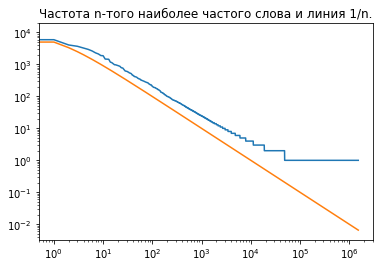

In [286]:
M = COUNTS['и'] # вместо "и" самое часто встречающееся слово
yscale('log'); 
xscale('log'); 
title('Частота n-того наиболее частого слова и линия 1/n.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)])

----------------------------------------------------------------------------
Но чем плох Bag of words? Тем, что для него кошк|у| != кошк|а| - два разных слова. Как это побороть? А что если мы вырежем все окончания и суффиксы, одним словом сделаем **стемминг Портера**. Тем самым мы будем считать что слово одно, а его форм много, но они уже не считаются за разные слова.

In [281]:
#что-то реализую
WORDS += WORDS2
#WORDS = [w for w in WORDS if len(w) > 2]

Но тогда возникает проблема, существуют слова, для которых стемминг не приведет к одному и тому же слову, например "шел и идти". Тогда на помощь приходят морфологические анализаторы, которые приводят слово к начальной форме (происходит лемматизация)

In [287]:
from pymystem3 import Mystem
text = "Красивая мама красиво мыла раму" 
m = Mystem()
lemmas = m.lemmatize(text)
print(''.join(lemmas))

красивый мама красиво мыть рама



In [288]:
import pymystem3
m1=pymystem3.Mystem()

m1.analyze('шел')

[{'analysis': [{'lex': 'идти', 'wt': 1, 'gr': 'V,несов,нп=прош,ед,изъяв,муж'}],
  'text': 'шел'},
 {'text': '\n'}]

Но в таком случае возникает проблема, что делать с "стекло" или "эти типы стали есть в прокатном цехе".
Морфологические анализаторы иногда делают ошибки и без контекста им не разобраться.
Но pymystem вроде как +- справляются

***Задача: Проверка Правописания***

Для данного слова w нужно найти наиболее вероятную правку *c = correct(w).*

**Подход:** Найти все кандидаты c, достаточно близкие к w. Выбрать наиболее вероятный из них.

Осталось понять, что такое близкие и наиболее вероятный.

Применим наивный подход: всегда будем брать более близкое слово, если проверки на близость недостаточно, берем слово с максимальной частотой из WORDS. 
Сейчас мы будем измерять близость с помощью расстояния Левенштейна: минимального необходимого количества удалений, перестановок, вставок, и замен символов, необходимых чтобы одно слово превратить в другое. Конечно же это не единственный возможный подход. Тогда остается определить функцию *correct(w):*

In [289]:
def correct(word):
    "Поиск лучшего исправления ошибки для данного слова."
    # предрассчитать edit_distance==0, затем 1, затем 2; в противном случае оставить слово "как есть".
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

Функции known и edits0 простые; функция edits2 iлегко получается из функции edits1:

In [291]:
def known(words):
    "Вернуть подмножество слов, которое есть в нашем словаре."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Вернуть все строки, которые находятся на edit_distance == 0 от word (т.е., просто само слово)."
    return {word}

def edits2(word):
    "Вернуть все строки, которые находятся на edit_distance == 2 от word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

Расстояние Левенштейна:

Исходное слово --> поиск

Вставка --> происк

Удаление --> п_иск

Замена --> поеск


In [292]:
def edits1(word):
    "Возвращает список всех строк на расстоянии edit_distance == 1 от word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Возвращает список всех возможных разбиений слова на пару (a, b)."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьяюя'

In [293]:
len(alphabet)

33

In [294]:
print(edits0('атец'))
print(edits1('атец'))
print(len(edits2('атец')))

{'атец'}
{'атрец', 'атшц', 'аткец', 'ятец', 'атем', 'атфец', 'атмец', 'атебц', 'атех', 'атеец', 'ыатец', 'атеце', 'отец', 'атпц', 'цтец', 'ачтец', 'ацец', 'атецл', 'азтец', 'атег', 'оатец', 'атце', 'атёц', 'атет', 'атъец', 'дтец', 'атдц', 'аатец', 'афец', 'алтец', 'атнец', 'аутец', 'атеж', 'атецё', 'асец', 'аъец', 'ажтец', 'атецм', 'ътец', 'атеь', 'атецж', 'атез', 'атезц', 'аыец', 'атечц', 'атецт', 'атедц', 'артец', 'ъатец', 'атецг', 'бтец', 'атаец', 'аткц', 'атецы', 'атеяц', 'цатец', 'атецв', 'атеы', 'ёатец', 'атоец', 'аеец', 'ытец', 'азец', 'мтец', 'нтец', 'аытец', 'атещ', 'атев', 'аетец', 'атець', 'иатец', 'атпец', 'атюец', 'атц', 'атед', 'атецъ', 'атежц', 'атею', 'ажец', 'адтец', 'атбец', 'атецб', 'аюец', 'ателц', 'анец', 'атгец', 'ааец', 'амец', 'атес', 'аятец', 'атеа', 'антец', 'ьтец', 'уатец', 'ахец', 'атфц', 'апец', 'атеё', 'атецу', 'атехц', 'итец', 'атек', 'атеоц', 'атецю', 'атзец', 'атея', 'атеиц', 'атсец', 'атецп', 'агец', 'атнц', 'катец', 'аштец', 'атецх', 'атьц', 'астец', 

In [295]:
tokens('Ана ни зочит в шшколу.')

['ана', 'ни', 'зочит', 'в', 'шшколу']

In [300]:
list(map(correct, tokens('Ога  хочит в шшколу.')))

['она', 'ре', 'хочет', 'в', 'школу']

***Теория: От счетчика слов к вероятностям последовательностей слов***

Нам нужно научиться подсчитывать вероятности слов, P(w). Делать мы это будем с помощью функции pdist, которая на вход принимает Counter (наш мешок слов) и возвращает функцию, выполняющую роль вероятностного распределения на множестве всех возможных слов. В вероятностном распределении вероятность каждого слова лежит между 0 и 1, и сложение вероятностей всех слов дает 1.

In [297]:
def pdist(counter):
    "Превращает частоты из Counter в вероятностное распределение."
    N = sum(list(counter.values()))
    return lambda x: counter[x]/N

P = pdist(COUNTS)

In [270]:
for w in tokens('То мать пирогов напечет, то бабушка с булочками приедет'):
    print(P(w), w)

0.0 то
5.543719228711097e-05 мать
1.16709878499181e-06 пирогов
5.83549392495905e-07 напечет
0.0 то
3.5012963549754295e-06 бабушка
0.0 с
5.83549392495905e-07 булочками
2.33419756998362e-06 приедет


Итак, что же такое вероятность последовательности слов? Используем определение совместной вероятности:
$P(w_1 ... w_n) = P(w_1)*P(w_2|w_1)*P(w_3|w_1w_2)...*...P(w_n|w_1...w_n-1)$

Модель мешка слов подразумевает, что каждое слово из мешка достается независимо от других. Это дает нам упрощенную аппроксимацию:
$P(w_1 ... w_n) = P(w_1)*P(w_2)*P(w_3)...*...P(w_n)$

Известный статистик Джордж Бокс сказал Все модели неверны, но некоторые полезны.

Как же нам посчитать $P(w_1 ... w_n)$? Мы будем использовать другое название, чтобы не обманывать себя, Pwords вместо P, и посчитаем ее как произведение индивидуальных вероятностей:

In [191]:
def Pwords(words):
    "Вероятности слов, при условии, что они независимы."
    return product(P(w) for w in words)

def product(nums):
    "Перемножим числа.  (Это как `sum`, только с умножением.)"
    result = 1
    for x in nums:
        result *= x
    return result

In [192]:
tests = ['тест', 
         'дом',
         'Крыжить']

for test in tests:
    print(Pwords(tokens(test)), test)

0.0 тест
0.0003806772696482654 дом
0.0 Крыжить


кажется, присвоить последнюю вероятность 0, неправильно; Она просто должна быть маленькой. К этому вернемся попозже. Ну а другие вероятности кажутся +- адекватными.

***Задача: Разбиение слов на сегменты***
Ситуации, когда слова пишутся слитно (по ошибке или нет)


Подход 2: Делаем одно разбиение - на первое слово и все остальное. Если предположить, что слова независимы, можно максимизировать вероятность первого слова + лучшего разбиения оставшихся букв.

<code>
assert segment('фотоальбом') == ['фото', 'альбом']
segment('choosespain') ==
   max(Pwords(['ф'] + segment('отоальбом')),
       Pwords(['фо'] + segment('тоальбом')),
       Pwords(['фот'] + segment('оальбом')),
       Pwords(['фото'] + segment('альбом')),
       ...
       Pwords(['фотоальбом'] + segment('')))
</code>

Чтобы сделать это хоть сколько-нибудь эффективным, нужно избежать слишком большого числа пересчетов оставшейся части слова. Это можно сделать или с помощью динамического программирования или с помощью мемоизации aka кэширования. Кроме того, для первого слова не обязательно брать все возможные варианты разбиений - мы можем установить максимальную длину. Какой она должна быть? Чуть большей, чем длина самого длинного слова, которое мы видели.

In [193]:
def memo(f):
    "Запомнить результаты исполнения функции f, чьи аргументы args должны быть хешируемыми."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

In [194]:
max(len(w) for w in COUNTS)

23

In [195]:
def splits(text, start=0, L=20):
    "Вернуть список всех пар (a, b); start <= len(a) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

In [196]:
print(splits('слово'))
print(splits('длинныйтекст', 3, 7))

[('', 'слово'), ('с', 'лово'), ('сл', 'ово'), ('сло', 'во'), ('слов', 'о'), ('слово', '')]
[('дли', 'нныйтекст'), ('длин', 'ныйтекст'), ('длинн', 'ыйтекст'), ('длинны', 'йтекст'), ('длинный', 'текст')]


In [302]:
@memo
def segment(text):
    "Вернуть список слов, который является наиболее вероятной сегментацией нашего текста."
    if not text: 
        return []
    else:
        candidates = ([first] + segment(rest) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=Pwords)

In [ ]:
segment('сдырочкой')

In [247]:
decl = ('предложениеэтосложнаясинтаксическаяконструкция')

In [248]:
print(segment(decl))

['п', 'р', 'е', 'д', 'л', 'о', 'ж', 'е', 'н', 'и', 'е', 'э', 'т', 'о', 'с', 'л', 'о', 'ж', 'н', 'а', 'я', 'с', 'и', 'н', 'т', 'а', 'к', 'с', 'и', 'ч', 'е', 'с', 'к', 'а', 'я', 'к', 'о', 'н', 'с', 'т', 'р', 'у', 'к', 'ц', 'и', 'я']


***Насколько дорого превращать одно слово в другое?***

Динамическое программирование позволяет разбить задачу на подзадачи, решив которые можно скомпоновать финальное решение. Мы будем пытаться превратить строку $source[0..i]$ в строку $target[0..j]$, мы сосчитаем все возможные комбинации подстрок $substrings[i, j]$ и рассчитаем их *edit_distance* до нашей исходной. Мы будем сохранять результаты в таблицу и переиспользовать их для расчета дальнейших изменений.


In [75]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: строка-исходник
        target: строка, в которую мы должны исходник превратить
        ins_cost: цена вставки
        del_cost: цена удаления
        rep_cost: цена замены буквы
    Output:
        D: матрица размера len(source)+1 на len(target)+1 содержащая минимальные расстояния edit_distance
        med: минимальное расстояние edit_distance (med), необходимое, 
        чтобы превратить строку source в строку target
    '''
    # стоимость удаления и вставки = 1
    m = len(source)
    n = len(target)

    # Заткнем нашу матрицу нулями
    D = np.zeros((m+1, n+1), dtype=int) 
    
    # Заполним первую колонку
    for row in range(1,m+1): 
        D[row,0] = D[row-1,0] + del_cost
        
    # Заполним первую строку
    for col in range(1,n+1): 
        D[0,col] = D[0,col-1] + ins_cost
        
    # Теперь пойдем от 1 к m-той строке
    for row in range(1,m+1): 
        
        # итерируемся по колонкам от 1 до n
        for col in range(1,n+1):
            
            # r_cost - стоимость замены
            r_cost = rep_cost
            
            # Совпадает ли буква исходного слова из предыдущей строки
            # с буквой целевого слова из предыдущей колонки, 
            if source[row-1] == target[col-1]:
                # Если они не нужны, то замена не нужна -> стоимость = 0
                r_cost = 0
                
            # Обновляем значение ячейки на базе предыдущих значений 
            # Считаем D[i,j] как минимум из трех возможных стоимостей (как в формуле выше)
            D[row,col] = min([D[row-1,col]+del_cost, D[row,col-1]+ins_cost, D[row-1,col-1]+r_cost])
          
    # установить edit_distance в значение из правого нижнего угла
    med = D[m,n]
    

    return D, med

In [76]:
import pandas as pd

source =  'кроты'
target = 'киты'
matrix, min_edits = min_edit_distance(source, target)

print("Расстояние: ",min_edits, "\n")

idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

Расстояние:  3 

   #  к  и  т  ы
#  0  1  2  3  4
к  1  0  1  2  3
р  2  1  2  3  4
о  3  2  3  4  5
т  4  3  4  3  4
ы  5  4  5  4  3


Нам мало миллионов слов в "обучающей выборке" давайте перейдем к МИЛЛИАРДАМ слов. Получив такой огромный объем информации, можно перейти к анализу пар последоваительных слов, не ожидая, что вероятности слишком часто будут обнуляться (представьте себе, сколько в языке может быть грамматически корректных сочетаний из двух слов). Мы вновь позаимствуем уже собранные данные у мистера Норвига. Лежат они на его сайте в формате "word \t count" для отдельных слов и в формате "word1 word2 \t count" для биграмм. Считаем их и упакуем в наши словари с вероятностями:

In [77]:
def load_counts(text, sep='\t'):
    """Возвращает Counter, полученный из пар ключ-значение,в каждой строке файла."""
    C = Counter()
    for i in [l.split('\t') for l in text.split('\n')][:-1]:
        key, count = i
        C[key] = int(count)
    return C

In [81]:
COUNTS1 = load_counts(requests.get('https://www.norvig.com/ngrams/count_1w.txt').text) #список слов с частотой их встречания
#COUNTS2 = список слов с частотой их встречания

P1w = pdist(COUNTS1)
#P2w = pdist(COUNTS2)

In [ ]:
print(type(COUNTS1))

In [ ]:
print(len(COUNTS1), sum(list(COUNTS1.values()))/1e9)
print(len(COUNTS2), sum(list(COUNTS2.values()))/1e9)

Ужас! Сотни миллиардов. Но мы справились.

In [ ]:
COUNTS2.most_common(30)

**Сегментация с помощью биграмм**
Чуть менее неправильная аппроксимация:
$P(w_1...w_n)=P(w_1)*P(w_2|w_1)*P(w_3|w_2)*...*...P(w_n|w_n-1)$
Эта штука называется биграммной моделью. Представьте, что вы взяли текст, достали из него все возможные пары подряд идущих слов и положили каждую пару в мешок, промаркированный ПЕРВЫМ словом из пары. После этого, чтобы сгенерировать кусок текста, мы берем первое слово из исходного мешка слов , а каждое следующее слово вынимаем из соответствующего мешка биграмм.

Начнем с определения вероятности текущего слова при условии данного предыдущего слова из Counter:

Отмечу, что для английского языка биграммная модель будет выглядеть так:
$P(w_1...w_n)=P(w_1)*P(w_2|w_1)*P(w_3|w_2)*...*...P(w_n|w_n-1)$ условная вероятность слова при условии предыдущего слова определяется так:
$P(w_n|w_n-1)=P(w_n-1w_n)/P(w_n-1)$

In [ ]:
def Pwords2(words, prev='<S>'):
    "Вероятность последовательности слов с помощью биграммной модели(при условии предыдущего слова)."
    return product(cPword(w, (prev if (i == 0) else words[i-1]) )
                   for (i, w) in enumerate(words))

# Перепишем Pwords на большой словарь P1w вместо Pword
def Pwords(words):
    "Вероятности слов при условии их независимости."
    return product(P1w(w) for w in words)

def cPword(word, prev):
    "Условная вероятность слова при условии предыдущего."
    bigram = prev + ' ' + word
    if P2w(bigram) > 0 and P1w(prev) > 0:
        return P2w(bigram) / P1w(prev)
    else: # если что-то не встретилось, поставим среднее между P1w и 0
        return P1w(word) / 2

In [ ]:
print(Pwords(tokens('Он приехал в город')))
print(Pwords2(tokens('Приехал он в город')))
print(Pwords2(tokens('Город в он приехал')))

Чтобы сделать segment2, скопируем segment, добавим в аргументы предыдущий токен, а вероятности будем считать с помощью Pwords2 вместо Pwords

In [123]:
@memo 
def segment2(text, prev='<S>'): 
    "Возвращает наилучшее разбиение текста, используя статистику биграмм." 
    if not text: 
        return []
    else:
        candidates = ([first] + segment2(rest, first) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=lambda words: Pwords2(words, prev))


In [ ]:
print(segment2('фотоальбом'))
print(segment2('поехалаонанет'))


Ну и что теперь? Биграммная модель вроде бы лучше, но не очень. Сотен миллиардов слов все равно может быть недостаточно. (Ну а почему бы не триллион слов?)

***Валидация***

До настоящего момента мы пытались интуитивно оценить результаты нашей работы. Тем не менее, никаких численных оценок качества мы пока не получили. Важно понимать, что без четких метрик слова "плохо"/"хорошо" не имеют никакого смысла. Более того - мы даже не можем четко ответить, было ли наше обновление модели в лучшую сторону или худшую. Обычно при построении неких прогностических моделей данные разбиваются на три части:

**Обучающая выборка**: То, что мы использовали для создания модели исправления ошибок; У нас это был файл words.txt file.
**Тестовая выборка**: Набор данных, который можно использовать для оценки качества вашей модели по ходу разработки.
**Валидационная выборка**: Набор данных, который мы используем для оценки работы программы после того как программа готова. Тестовая выборка для этого быть использована не может—Стоит разработчику посмотреть на результаты на тестовой выборке, она уже "испорчена". В принципе, программист может изменить программу так, чтобы она "подгонялась" под тестовую выборку, а это будет "переобучением". Вот почему нам нужен отдельный набор тестов, который рассматривается только после завершения разработки..

Для нашей программы обучающая выборка - словарь слов. Сделаем валидационную выборку.

In [215]:
def test_segmenter(segmenter, tests):
    "Оценка сегментатора на тестовых данных; вывести на печать ошибки; вернуть долю верно разбитого."
    return sum([test_one_segment(segmenter, test) 
               for test in tests]), len(tests)

def test_one_segment(segmenter, test):
    words = tokens(test)
    result = segmenter(''.join(words))
    correct = (result == words)
    if not correct:
        print('expected', words)
        print('got     ', result) 
    return correct

proverbs = ("""Унас под крыльцом живут ежи. По вечерам вся смья выходит гулять.""".splitlines())

In [216]:
test_segmenter(segment, proverbs)

expected ['унас', 'под', 'крыльцом', 'живут', 'ежи', 'по', 'вечерам', 'вся', 'смья', 'выходит', 'гулять']
got      ['унасподкрыльцомживутежиповечерамвсясмьявыходитгулять']


(0, 1)

**Место для анекдота про Лапласа**

Однажды французского математика Лапласа спросили: "Какова вероятность того, что Солнце завтра взойдет?". Из данных, что оно из  ближайших дней взошло n раз следует оценка максимального правдоподобия n/n = 1. Но Лапласу хотелось чуть сбалансировать оценку на шанс того, что завтра Солнце может и не взойти, поэтому он дал оценку (n+1)/(n+2).

То, что мы знаем, ограничено, а то, чего мы не знаем,-бесконечно
— Пьер Симон Лаплас, 1749-1827

In [86]:
def pdist_additive_smoothed(counter, c=1):
    """Вероятность слова, при условии данных из Counter'a.
    добавляем c к частоте каждого слова + слово 'unknown'."""
    N = sum(list(counter.values()))          # суммарное кол-во слов
    Nplus = N + c * (len(counter) + 1) # кол-во слов + сглаживание
    return lambda word: (counter[word] + c) / Nplus 

P1w = pdist_additive_smoothed(COUNTS1)

Теперь еще одна проблема ... у нас появились незнакомые слова с ненулевой вероятностью. А что если 10-12 - приемлемая вероятность для слов нашего текста: то есть, если я читаю новый текст, вероятность того, что следующее слово мне незнакомо, может быть порядка 10-12. Но если я случайно генерирую 20-буквенный последовательности, вероятность того, что одна из них будет реальным словом намного меньше чем 10-12.

У нас две проблемы:

Во-первых, у нас нет четкой модели для неизвестных слов. Мы говорим "неизвестное слово", но не различаем более вероятные неизвестные слова и менее вероятные неизвестные слова. Ну, например, вероятнее ли 8-буквенное неизвестное слово чем 20-буквенное неизвестное слово?

Во-вторых, мы не берем в расчет информацию из частей неизвестных слов. Например, "unglobulate" явно должно быть более вероятным чем "zxfkogultae".

Для нашего следующего подхода мы используем идеи метода Гуда - Тьюринга. Он оценивает вероятности слов, не встретившихся в нашем Counter'е, на основании вероятностей слов, встретившихся единожды (Можно туда же подключить вероятности для встретившихся 2 раза и т.д.).

Итак, сколько слов встретилось 1 раз в COUNTS? (В COUNTS1 ни одного такого слова нет.) И какие длины у этих слов? Давайте посмотрим:


In [87]:
singletons = (w for w in COUNTS if COUNTS[w] == 1)
lengths = list(map(len, singletons))
Counter(lengths).most_common()

[(8, 4418),
 (7, 4190),
 (9, 3967),
 (10, 3273),
 (6, 2820),
 (11, 2472),
 (12, 1615),
 (5, 1612),
 (13, 910),
 (14, 575),
 (4, 574),
 (15, 313),
 (3, 191),
 (16, 164),
 (17, 82),
 (2, 44),
 (18, 42),
 (19, 18),
 (20, 9),
 (21, 5),
 (1, 2),
 (23, 2),
 (22, 1)]

In [ ]:
matplotlib.pyplot.hist(lengths, bins=len(set(lengths)));

Длины таких слов распределены похоже на нормальное распределение :)

In [ ]:
def pdist_good_turing_hack(counter, onecounter, base=1/33., prior=1e-8):
    """Вероятность слова при условии данных из счетчика.
    Для неизвестных слов, смотрим на слова, встретившиеся единожды из onecounter, 
    вероятность выбираем, основываясь на длине.
    Воспользуемся идеей метода Гуда-Тьюринга(полностью мы его здесь не реализуем).
    prior -добавочный фактор, который сделает неизвестные слова менее вероятными.
    base -то, насколько мы уменьшаем вероятность за длину слова больше максимального."""
    N = sum(list(counter.values()))
    N2 = sum(list(onecounter.values()))
    lengths = list(map(len, [w for w in onecounter if onecounter[w] == 1]))
    ones = Counter(lengths)
    longest = max(ones)
    return (lambda word: 
            counter[word] / N if (word in counter) 
            else prior * (ones[len(word)] / N2 or 
                          ones[longest] / N2 * base ** (len(word)-longest)))
#Переопределим P1w
P1w = pdist_good_turing_hack(COUNTS1, COUNTS)

In [ ]:
segment.cache.clear()
segment('какой-то сегмент')

***Задача: Что если слово находится очень далеко по edit_distance, но звучит точно так же?***
Часто можно встретить ошибки в текстах, вызванные неграмотным написанием слов. Особенно часто это происходит в случае иностранных фамилий или транслитерированной терминологии. Обычно в таких случаях в пример приводят написание фамилии

Для такого случая можно использовать следующую методологию. Давайте привлечем лингвистов и составим правила, которые одинаково звучащим словам будут ставить в соответствие один и тот же код. Допустим, с помощью лингвистов мы такой алгоритм придумали. Тогда дальнейшие наши действия таковы:

1) Сделать словарь с вероятностями слов (как мы делали из мешка слов)

2) Сделать словарь соответствий код слова -> слово (с помощью того самого алгоритма от лингвистов). 
    Если есть в списке есть слова с одинаковым кодом, выбирать будем наиболее частое слово.

3) Сделаем аналогичный edit_distance алгоритм на множестве кодов слов

4) Найдя соответствующую замену для слова в виде его кода, восстановим слово с помощью словаря из пункта 2

Алгоритм, про который мы поговорим, называется Double Metaphone.

In [ ]:
import metaphone
from metaphone import doublemetaphone

Алгоритм возвращает кортеж из двух возможных фонетических кодов слова. Правило такое:

 (Primary Key = Primary Key) = Идеальное совпадение
 
 (Secondary Key = Primary Key) = Совпадение
 
 (Primary Key = Secondary Key) = Совпадение
 
 (Alternate Key = Alternate Key) = Совпадение +-
 


# THE END

У Норвига в статье код занимает 21 строчку: 


In [ ]:
import re, collections
def words(text):
    return re.findall('[а-ё]+', text.lower())
def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model
    
with codecs.open('words.txt', 'r', encoding = 'windows 1251') as file:
    TEXT = file.read().replace('\n', ' ')

NWORDS = train(words(TEXT))
alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
def edits1(word):
    n = len(word)
    return set( [word[0:i]+word[i+1:] for i in range(n)] +                      # deletion
                [word[0:i]+word[i+1]+word[i]+word[i+2:] for i in range(n-1)] +   # transposition
                [word[0:i]+c+word[i+1:] for i in range(n) for c in alphabet] +    # alteration
                [word[0:i]+c+word[i:] for i in range(n+1) for c in alphabet])    # insertion
def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)
def known(words): return set(w for w in words if w in NWORDS)
def correct(word):
    candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
    return max(candidates, key=lambda w: NWORDS[w])


Использовать этот код нужно следующим образом –



In [ ]:
to_correct = tokens('Саничка не хочит в шшклу')

for word in to_correct:
    print(correct(word), end = ' ') 